In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from pathlib import Path
%matplotlib inline

In [2]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [3]:
PATH = Path("./MNIST")

In [4]:
device = "cuda:6" if torch.cuda.is_available() else "cpu"

In [5]:
tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [6]:
train_ds = datasets.MNIST(PATH, train=True, download=True, transform=tfms)
test_ds = datasets.MNIST(PATH, train=False, download=True, transform=tfms)

In [7]:
train_dl = data.DataLoader(train_ds, batch_size=64)
test_dl = data.DataLoader(test_ds, batch_size=64, shuffle=False)

In [8]:
class Encoder(nn.Module):
    def __init__(self, input_size, latent_size):
        super().__init__()
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 10)
        
        
    def forward(self, x):
        x = F.tanh(self.fc1(x))
        return x

In [9]:
class Classifier(nn.Module):
    def __init__(self, input_size, lr=1e-4, l2=0.):
        super().__init__()
        self.input_size = input_size
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 10)
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        self.loss_fn = F.nll_loss
    
    def forward(self, x):
        x = x.view(-1, self.input_size)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)
        return x
    
    def loss(self, pred, target):
        self._loss = self.loss_fn(pred, target)
        return self._loss

In [10]:
def train(epoch, model, train_loader):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)
        model.optim.zero_grad()
        output = model(data)
        loss = model.loss(output, target)
        loss.backward()
        model.optim.step()   
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss  {:.6f}'.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader), model._loss.item())
        print(line)
    return model._loss.item()

In [11]:
def test(model, loader, ds):
    test_size = len(loader.sampler)
    avg_lambda = lambda l: 'Loss: {:.4f}'.format(l)
    acc_lambda = lambda c, p: 'Accuracy: {}/{} ({:.0f}%)'.format(c, test_size, p)
    line = lambda l, c, p: ' ' + avg_lambda(l) + '\t' + acc_lambda(c, p)

    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in loader:
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            test_loss += model.loss(output, target).item() # sum up batch loss
            _, pred = torch.max(output.data, 1)
            correct += (pred == target).sum().item()
    
    test_loss /= test_size
    correct_pct = correct / test_size
    report = ''+ds+' set:\n' + line(test_loss, correct, 100.0 * correct_pct) + '\n'
    
    print(report)
    return test_loss, correct_pct

In [12]:
def plot_images(images, shape):
    fig = plt.figure(figsize=shape[::-1], dpi=80)
    for j in range(1, len(images) + 1):
        ax = fig.add_subplot(shape[0], shape[1], j)
        ax.matshow(images[j - 1, 0, :, :], cmap = matplotlib.cm.binary)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
    plt.show()

In [13]:
model = Classifier(28*28).to(device)

In [14]:
%%time
for epoch in range(1,101):
    model.train()
    train(epoch, model, train_dl)
    test(model, test_dl, 'Test')

Train Epoch: 1 [30016/60000 (100%)]	Loss  0.266227
Test set:
 Loss: 0.0057	Accuracy: 8917/10000 (89%)

Train Epoch: 2 [30016/60000 (100%)]	Loss  0.175925
Test set:
 Loss: 0.0046	Accuracy: 9116/10000 (91%)

Train Epoch: 3 [30016/60000 (100%)]	Loss  0.119545
Test set:
 Loss: 0.0040	Accuracy: 9245/10000 (92%)

Train Epoch: 4 [30016/60000 (100%)]	Loss  0.079860
Test set:
 Loss: 0.0036	Accuracy: 9333/10000 (93%)

Train Epoch: 5 [30016/60000 (100%)]	Loss  0.056426
Test set:
 Loss: 0.0032	Accuracy: 9390/10000 (94%)

Train Epoch: 6 [30016/60000 (100%)]	Loss  0.044370
Test set:
 Loss: 0.0029	Accuracy: 9433/10000 (94%)

Train Epoch: 7 [30016/60000 (100%)]	Loss  0.037945
Test set:
 Loss: 0.0027	Accuracy: 9489/10000 (95%)

Train Epoch: 8 [30016/60000 (100%)]	Loss  0.034029
Test set:
 Loss: 0.0024	Accuracy: 9528/10000 (95%)

Train Epoch: 9 [30016/60000 (100%)]	Loss  0.032212
Test set:
 Loss: 0.0023	Accuracy: 9556/10000 (96%)

Train Epoch: 10 [30016/60000 (100%)]	Loss  0.030169
Test set:
 Loss: 0.00

Train Epoch: 80 [30016/60000 (100%)]	Loss  0.000261
Test set:
 Loss: 0.0018	Accuracy: 9783/10000 (98%)

Train Epoch: 81 [30016/60000 (100%)]	Loss  0.000193
Test set:
 Loss: 0.0018	Accuracy: 9792/10000 (98%)

Train Epoch: 82 [30016/60000 (100%)]	Loss  0.000309
Test set:
 Loss: 0.0018	Accuracy: 9785/10000 (98%)

Train Epoch: 83 [30016/60000 (100%)]	Loss  0.000065
Test set:
 Loss: 0.0018	Accuracy: 9790/10000 (98%)

Train Epoch: 84 [30016/60000 (100%)]	Loss  0.000159
Test set:
 Loss: 0.0018	Accuracy: 9777/10000 (98%)

Train Epoch: 85 [30016/60000 (100%)]	Loss  0.000144
Test set:
 Loss: 0.0017	Accuracy: 9789/10000 (98%)

Train Epoch: 86 [30016/60000 (100%)]	Loss  0.000064
Test set:
 Loss: 0.0017	Accuracy: 9790/10000 (98%)

Train Epoch: 87 [30016/60000 (100%)]	Loss  0.000023
Test set:
 Loss: 0.0018	Accuracy: 9773/10000 (98%)

Train Epoch: 88 [30016/60000 (100%)]	Loss  0.000045
Test set:
 Loss: 0.0017	Accuracy: 9783/10000 (98%)

Train Epoch: 89 [30016/60000 (100%)]	Loss  0.000048
Test set:
 L

In [15]:
torch.save(model.state_dict(), PATH / "ae_classifier.model")

In [16]:
test_dl = data.DataLoader(test_ds, batch_size=1, shuffle=False)

In [17]:
w, c = next(iter(test_dl))

### Original image

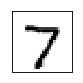

In [18]:
plot_images(w, (1,1))

### Class of original image

In [19]:
c.item()

7

In [20]:
class FitToClass(nn.Module):
    def __init__(self, data, target_class):
        super().__init__()
        self._loss = None
        self.target_class = torch.tensor([target_class]).to(device)
        self.w = nn.Parameter(data)
        self.optim = optim.Adam(self.parameters(), lr=1e-4)
        
    def forward(self):
        out = model(self.w)
        return out
    
    def loss(self, out):
        self._loss = F.nll_loss(out, self.target_class)
        return self._loss

### Try to change class of image to 8

In [21]:
model.eval()

m = FitToClass(w, 8).to(device)
m.train()

for i in range(1, 30_001):
    m.optim.zero_grad()
    out = m()
    loss = m.loss(out)
    loss.backward()
    m.optim.step()
    if i % 1000 == 0:
        print(loss.item())

4.237902641296387
0.04878091812133789
0.01614236831665039
0.007331371307373047
0.0038385391235351562
0.0021462440490722656
0.0012426376342773438
0.0007271766662597656
0.0004315376281738281
0.000255584716796875
0.00015211105346679688
9.012222290039062e-05
5.245208740234375e-05
3.147125244140625e-05
1.8596649169921875e-05
1.1444091796875e-05
6.67572021484375e-06
3.814697265625e-06
2.86102294921875e-06
1.9073486328125e-06
9.5367431640625e-07
9.5367431640625e-07
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [22]:
target_img = m.w.detach()

### Predict class of target image with trained classifier

In [23]:
torch.argmax(model(target_img)).item()

8

### Plot target image

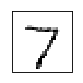

In [24]:
plot_images(target_img.view(-1, 1, 28, 28).clamp(0, 1).data.cpu().numpy(), (1,1))